In [1]:
import pandas as pd
import logging
from pathlib import Path
from utils.data_loading import SGCCDataset
import torch
from unet import UNet_1D, UNet_1D_N, UNet_1D_L, UNet_1D_NN
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def predict_data(net,
                data,
                device,
                out_threshold=0.5):
    net.eval()
    data = data.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        print(data.shape)
        output = net(data).cpu()
        # print(output.size())
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold
        # print(mask.size())
    return mask[0].long().squeeze().numpy()

In [3]:
id = 'SGCC'
dir_checkpoint = Path(f'./checkpoints_pseudo_{id}/')

In [4]:
zx3_normalized = pd.read_csv(f'./data/{id}_data/data_prepared/zx1_normalized.csv') 
normal3_normalized = pd.read_csv(f'./data/{id}_data/data_prepared/Normal3_normalized.csv')
# Rename the columns of df2 to match df1
normal3_normalized.columns = zx3_normalized.columns

zy3 = pd.read_csv(f'./data/{id}_data/data_prepared/zy1.csv') 
normal3_normalized_label = pd.read_csv(f'./data/{id}_data/data_prepared/Normal3_normalized_label.csv')
normal3_normalized_label.columns = zy3.columns

combined_dfx = pd.concat([zx3_normalized, normal3_normalized], ignore_index=True)#
combined_dfy = pd.concat([zy3, normal3_normalized_label], ignore_index=True)#


combined_dfx.to_csv(f'./data/{id}_data/data_prepared/combined_dfx.csv', index=False)
combined_dfy.to_csv(f'./data/{id}_data/data_prepared/combined_dfy.csv', index=False)


# normal3_normalized_sudolabel = pd.read_csv(f'./Normal3_normalized_sudolabel.csv')
# normal3_normalized_sudolabel.columns = zy3.columns
# combined_dfy_sudo = pd.concat([zy3, normal3_normalized_sudolabel], ignore_index=True)#
# combined_dfy_sudo.to_csv('./combined_dfy_sudo.csv', index=False)

# normal3_normalized_sudolabel1 = pd.read_csv(f'./Normal3_normalized_sudolabel1.csv')
# normal3_normalized_sudolabel1.columns = zy3.columns
# combined_dfy_sudo1 = pd.concat([zy3, normal3_normalized_sudolabel1], ignore_index=True)#
# combined_dfy_sudo1.to_csv('./combined_dfy_sudo1.csv', index=False)

normal3_normalized_pseudolabel2 = pd.read_csv(f'./data/{id}_data/data_prepared/Normal3_normalized_pseudolabel.csv')
normal3_normalized_pseudolabel2.columns = zy3.columns
combined_dfy_pseudo2 = pd.concat([zy3, normal3_normalized_pseudolabel2], ignore_index=True)#
combined_dfy_pseudo2.to_csv(f'./data/{id}_data/data_prepared/combined_dfy_pseudo.csv', index=False)

In [5]:
combined_dfy_pseudo2.shape

(2775, 304)

In [6]:
##### testing 用的predict_t.py
# id = ''
##### 改变的地方是：
dir_data = Path(f'./data/{id}_data/data_prepared/combined_dfx.csv')
# dir_mask = Path('./combined_dfy.csv')
dir_mask = Path(f'./data/{id}_data/data_prepared/combined_dfy_pseudo.csv')
dataset = SGCCDataset(dir_data, dir_mask)

val_percent: float = 0.1
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data = dataset.data_tensor
mask = dataset.mask_tensor

data_train = torch.tensor(np.array([train_set[i]['data'] for i in range(len(train_set))]).squeeze())
mask_train = torch.tensor(np.array([train_set[i]['mask'] for i in range(len(train_set))]).squeeze())

data_val = torch.tensor(np.array([val_set[i]['data'] for i in range(len(val_set))]).squeeze())
mask_val = torch.tensor(np.array([val_set[i]['mask'] for i in range(len(val_set))]).squeeze())

net = UNet_1D(n_channels=1, n_classes=2, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device=device)
# state_dict = torch.load('./checkpoints/checkpoint_epoch21.pth', map_location=device)
# state_dict = torch.load('./checkpoints_Attack3_pure/checkpoint_epoch20.pth', map_location=device)##old attack 3
# state_dict = torch.load('./checkpoints_Attack3_pure/checkpoint_epoch20_combined.pth', map_location=device)##old attack 3+new 3000 normal data
# state_dict = torch.load('./checkpoints_Attack3_pure/checkpoint_epoch20_combine_sudo.pth', map_location=device)##old attack 3+new 3000 normal data+sudo label
# state_dict = torch.load(f'./checkpoints_sudo_{id}/checkpoint_epoch20.pth', map_location=device)##old attack 3+new 
# 3000 normal data + pseudo label
state_dict = torch.load(f'./checkpoints_pseudo_{id}/checkpoint_epoch20.pth', map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
data_val.shape, mask_val.shape

(torch.Size([277, 304]), torch.Size([277, 304]))

In [8]:
val_set[0].keys()

dict_keys(['data', 'mask'])

In [9]:
result = []
pred_ts = []
for i in range(len(data_val)):
    item = data_val[i, :].unsqueeze(0).unsqueeze(0)
    print(item.shape)
    
    mask = predict_data(net=net,
                        data=item,
                        out_threshold=0.5,
                        device=device)

    result.append(mask)

torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1, 304])
torch.Size([1, 1

/tmp/ipykernel_21432/1509602748.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  zy = pd.DataFrame(np.array(mask_val).astype(int))


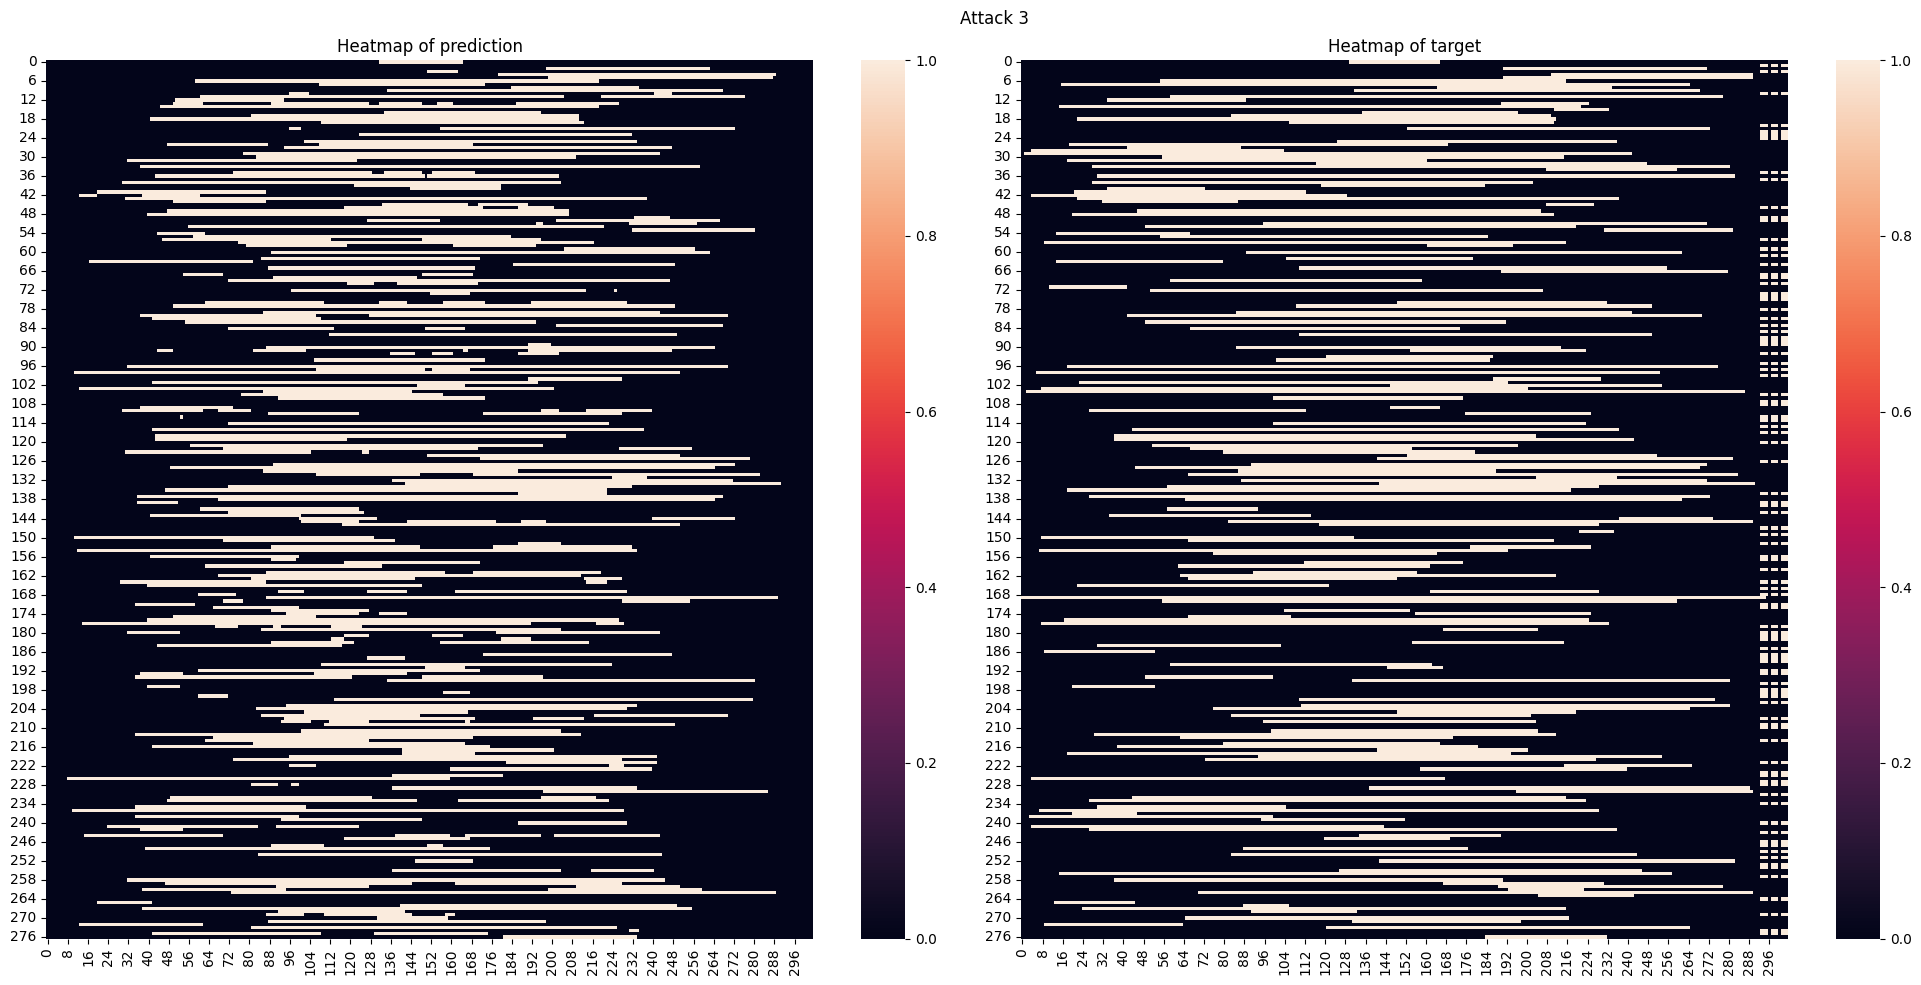

In [10]:
result_df = pd.DataFrame(result)
# result_df.to_csv('result.csv', index=False)
zy = pd.DataFrame(np.array(mask_val).astype(int))
# zy = pd.read_csv('./combined_dfy.csv')
# zy = pd.read_csv(f'./data/{id}_data/data_prepared/combined_dfy_pseudo.csv')
# zy = pd.read_csv('.\Attack3_normalized_label.csv')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'Attack 3')   

# Plot the first heatmap
sns.heatmap(result_df, ax=ax1)
ax1.set_title('Heatmap of prediction')

# Plot the second heatmap
sns.heatmap(zy, ax=ax2)
ax2.set_title('Heatmap of target')

# Display the plot
plt.tight_layout()
# plt.savefig(f'result{id}.png')
plt.show()

In [11]:
result_df.shape, zy.shape

((277, 304), (277, 304))

In [12]:
# 检测窃电，如果连续有7个1，就标记为窃电
def mark_continuous_ones(df, threshold=7):
    def has_continuous_ones(row):
        count = 0
        for value in row:
            if value == 1:
                count += 1
                if count >= threshold:
                    return True
            else:
                count = 0
        return False

    return df.apply(has_continuous_ones, axis=1)

In [13]:
# Example usage:
result_marked = mark_continuous_ones(result_df)
zy_marked = mark_continuous_ones(zy, threshold=7)

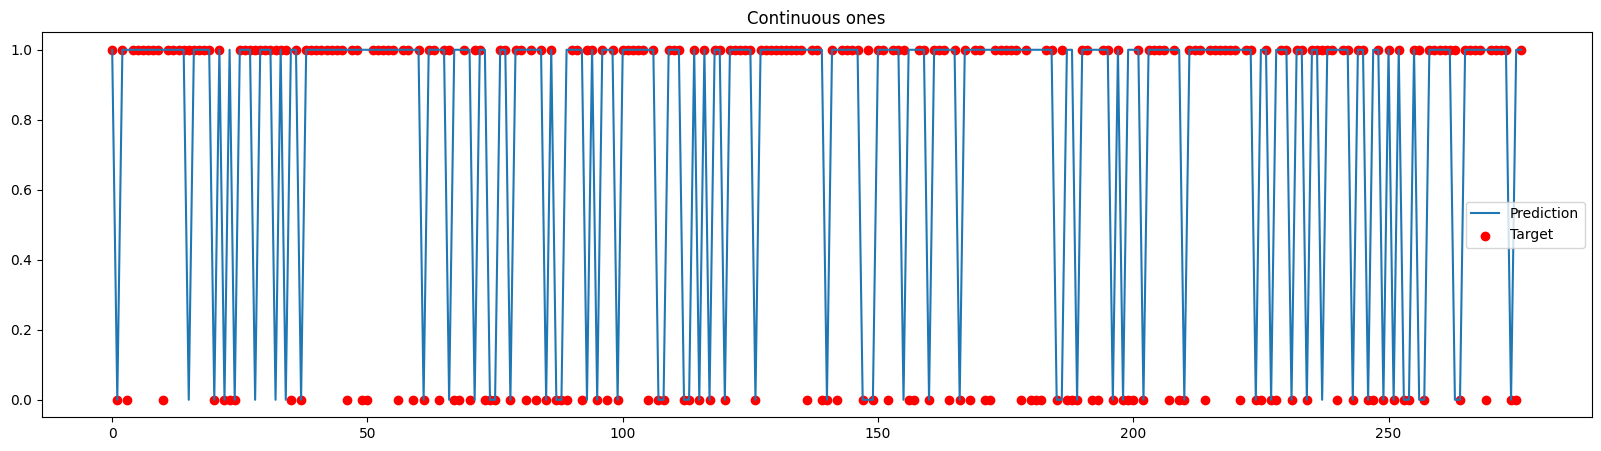

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(result_marked, label='Prediction')
plt.scatter(np.arange(len(zy_marked)), zy_marked, label='Target', color='red')
plt.title('Continuous ones')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

# Calculate accuracy
accuracy = accuracy_score(zy_marked, result_marked)

# Calculate F1 score
f1 = f1_score(zy_marked, result_marked)

# Calculate recall
recall = recall_score(zy_marked, result_marked)

auc = roc_auc_score(zy_marked, result_marked)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')

Accuracy: 0.7725631768953068
F1 Score: 0.8421052631578947
Recall: 0.9281767955801105
AUC: 0.7036717311233885
